In [36]:
import os

import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as pl
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import talib


In [43]:
# Load the dataset
data = pd.read_csv("C:\\Users\\Hasan\\Desktop\\data science folder\\AAPL_historical_data.csv")

# Display basic information
print(data.head())

         Date      Open      High       Low     Close  Adj Close     Volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


In [44]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10998 entries, 0 to 10997
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          10998 non-null  object 
 1   Open          10998 non-null  float64
 2   High          10998 non-null  float64
 3   Low           10998 non-null  float64
 4   Close         10998 non-null  float64
 5   Adj Close     10998 non-null  float64
 6   Volume        10998 non-null  int64  
 7   Dividends     10998 non-null  float64
 8   Stock Splits  10998 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 773.4+ KB
None


In [46]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)  # Set Date as the index if it's time-series data

In [47]:
print(data.describe())

               Open          High           Low         Close     Adj Close  \
count  10998.000000  10998.000000  10998.000000  10998.000000  10998.000000   
mean      22.299160     22.539055     22.068367     22.312754     21.494496   
std       46.003685     46.496031     45.540929     46.037660     45.561916   
min        0.049665      0.049665      0.049107      0.049107      0.037857   
25%        0.299107      0.303710      0.290179      0.298549      0.241840   
50%        0.531250      0.537946      0.522321      0.531250      0.432079   
75%       20.204196     20.389554     19.998036     20.196160     17.253029   
max      236.479996    237.229996    233.089996    234.820007    234.548523   

             Volume     Dividends  Stock Splits  
count  1.099800e+04  10998.000000  10998.000000  
mean   3.180806e+08      0.000752      0.001546  
std    3.354523e+08      0.011753      0.083663  
min    0.000000e+00      0.000000      0.000000  
25%    1.132545e+08      0.000000     

In [49]:
# Check for missing values
print(data.isnull().sum())

# Optionally, fill or drop missing values
data.fillna(method='ffill', inplace=True)  # Forward fill
data.dropna(inplace=True)  # Drop rows with missing values


Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


C:\Users\Hasan\AppData\Local\Temp\ipykernel_13140\4081964333.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill


In [55]:
# Apply Technical Indicators using TA-Lib 
# Add a 20-day Simple Moving Average (SMA) and Exponential Moving Average (EMA)
data['SMA_20'] = talib.SMA(data['Close'], timeperiod=20)
data['EMA_20'] = talib.EMA(data['Close'], timeperiod=20)
#Relative Strength Index (RSI)
data['RSI'] = talib.RSI(data['Close'], timeperiod=14)
#Identify price volatility using Bollinger Bands
data['Upper_Band'], data['Middle_Band'], data['Lower_Band'] = talib.BBANDS(
    data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)


In [60]:
#MACD (Moving Average Convergence Divergence
data['MACD'], data['MACD_Signal'], data['MACD_Hist'] = talib.MACD(
    data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
#Average True Range (ATR)
data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
# Example: Detect Bullish Engulfing Pattern
data['Bullish_Engulfing'] = talib.CDLENGULFING(
    data['Open'], data['High'], data['Low'], data['Close']
)


In [63]:
#Combine multiple indicators to identify trading opportunities
data['Buy_Signal'] = (data['RSI'] < 20) & (data['Close'] < data['Lower_Band'])
data['Sell_Signal'] = (data['RSI'] > 80) & (data['Close'] > data['Upper_Band'])

# Display buy/sell signals
print(data[['Close', 'RSI', 'Buy_Signal', 'Sell_Signal']].tail())


                 Close        RSI  Buy_Signal  Sell_Signal
Date                                                      
2024-07-24  218.539993  48.687742       False        False
2024-07-25  217.490005  47.386437       False        False
2024-07-26  217.960007  48.055700       False        False
2024-07-29  218.240005  48.476184       False        False
2024-07-30  218.800003  49.359115       False        False


In [64]:
#Simple Moving Average Crossover
# Signal: Buy when SMA_20 > EMA_20, Sell when SMA_20 < EMA_20
data['Signal'] = 0
data.loc[data['SMA_20'] > data['EMA_20'], 'Signal'] = 1  # Buy signal
data.loc[data['SMA_20'] < data['EMA_20'], 'Signal'] = -1  # Sell signal

# View the strategy
print(data[['Close', 'SMA_20', 'EMA_20', 'Signal']].tail())


                 Close      SMA_20      EMA_20  Signal
Date                                                  
2024-07-24  218.539993  224.228500  222.376929       1
2024-07-25  217.490005  224.440500  221.911508       1
2024-07-26  217.960007  224.633500  221.535174       1
2024-07-29  218.240005  225.014500  221.221349       1
2024-07-30  218.800003  225.117001  220.990744       1


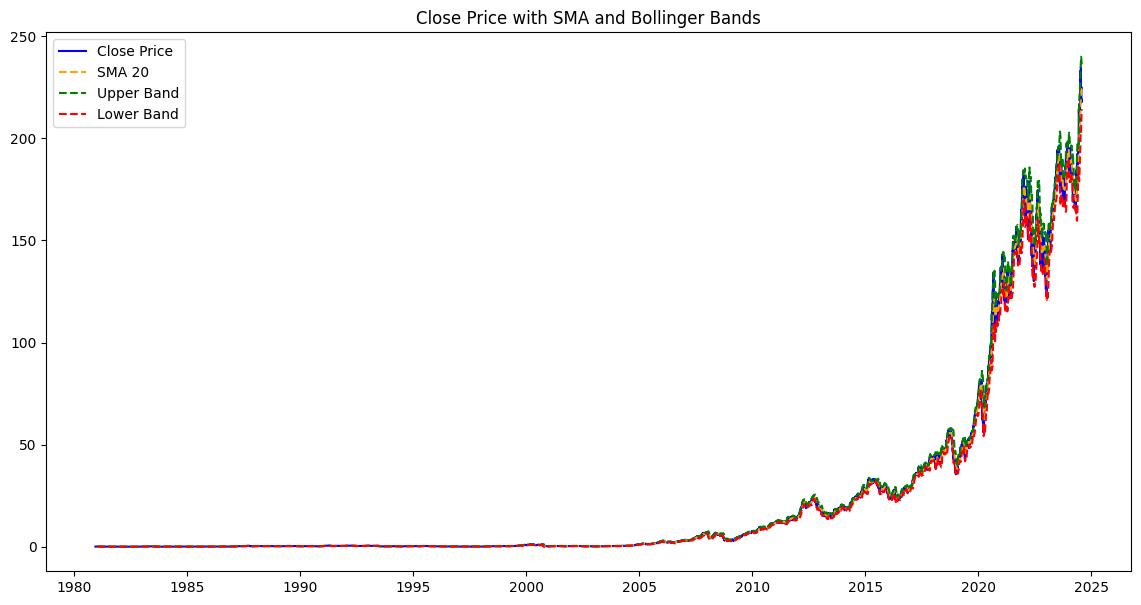

In [67]:
#Plot Close Price, SMA, and Bollinger Bands
plt.figure(figsize=(14, 7))

# Plot Close Price
plt.plot(data.index, data['Close'], label='Close Price', color='blue')

# Plot SMA and Bollinger Bands
plt.plot(data.index, data['SMA_20'], label='SMA 20', color='orange', linestyle='--')
plt.plot(data.index, data['Upper_Band'], label='Upper Band', color='green', linestyle='--')
plt.plot(data.index, data['Lower_Band'], label='Lower Band', color='red', linestyle='--')

plt.title('Close Price with SMA and Bollinger Bands')
plt.legend()
plt.show()